<a href="https://colab.research.google.com/github/JoeJoe1313/Recommender-Systems/blob/master/Content_based_Recommender_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

#Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

#Data


## Data Downloading


In [ ]:
!gsutil cp -r gs://rec-sys-fmi/hw2-dataset .

Copying gs://rec-sys-fmi/hw2-dataset/shared_articles.csv...
Copying gs://rec-sys-fmi/hw2-dataset/users_interactions.csv...
- [2 files][ 28.6 MiB/ 28.6 MiB]                                                
Operation completed over 2 objects/28.6 MiB.                                     


In [ ]:
!ls .

hw2-dataset  sample_data


##EDA

In [ ]:
users_interactions_df = pd.read_csv("hw2-dataset/users_interactions.csv")
articles_df = pd.read_csv("hw2-dataset/shared_articles.csv")

###user interactions EDA and cleaning


In [ ]:
users_interactions_df[0:2]

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [ ]:
#number of distinct users
len(users_interactions_df.personId.value_counts())


1895

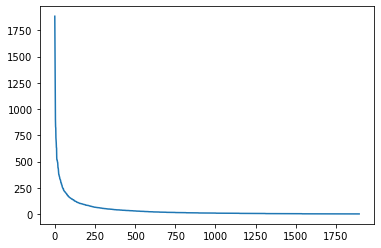

In [ ]:
# interactions per user
plt.plot(range(0,len(users_interactions_df.personId.value_counts())),users_interactions_df.personId.value_counts())

In [ ]:
users_interactions_df.eventType.value_counts()

VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
Name: eventType, dtype: int64

In [ ]:
users_interactions_df = users_interactions_df[["contentId","personId","eventType"]]
users_interactions_df[0:2]

,contentId,personId,eventType
0,-3499919498720038879,-8845298781299428018,VIEW
1,8890720798209849691,-1032019229384696495,VIEW


In [ ]:
users_interactions_df.eventType.value_counts()

VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
Name: eventType, dtype: int64

In [ ]:
users_interactions_df.personId.value_counts()

-1032019229384696495    1885
-1443636648652872475    1616
 3609194402293569455    1435
-2626634673110551643    1084
-3596626804281480007     903
                        ... 
 8471654280763064040       1
-4611063622188844434       1
-155245639726091910        1
 2360366466703086037       1
 4391185772225937239       1
Name: personId, Length: 1895, dtype: int64

In [ ]:
users_interactions_df.contentId.value_counts()

-4029704725707465084    433
-133139342397538859     315
-6783772548752091658    294
 8657408509986329668    294
-6843047699859121724    281
                       ... 
-8980834789053459155      1
 5518462222339671372      1
-3946932055798267834      1
 163780025692404854       1
 5232169374213306041      1
Name: contentId, Length: 2987, dtype: int64

In [ ]:
users_interactions_df.shape

(72312, 3)

In [ ]:
users_interactions_df.drop_duplicates(["contentId","personId"]).shape

(40710, 3)

In [ ]:
#will leave only one record for user content, as in order to combine the diffent events will score them - view is implicit preference so 1 point, 
# like/comment/bookmark/follow are explicit/implicit preferences that probably the user like it so 5 points. after that will aggragete with leaving the highest score, so if user viewed,liked and comment the score will still be 5(not higher)

di = {"VIEW":1, "LIKE":5,"BOOKMARK":5,"COMMENT CREATED":5,"FOLLOW":5}
users_interactions_df["prefScore"] = users_interactions_df["eventType"].map(di)


In [ ]:
users_interactions_df.drop("eventType",1) # removing the "eventType" colomn
users_interactions_df = users_interactions_df.groupby(["contentId","personId"]).max().reset_index()

In [ ]:
#for the cold start problem
#lets drop all the users for which we don't have at least 5*6 scores (5 explicit prefenrences or correspondant number of implicit ones)
users_interactions_count_df = users_interactions_df.groupby('personId').sum()
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df["prefScore"] >= 30].reset_index()[["personId","prefScore"]]
users_with_enough_interactions_df

,personId,prefScore
0,-9223121837663643404,43.0
1,-9109785559521267180,43.0
2,-9016528795238256703,342.0
3,-9009798162809551896,288.0
4,-9001583565812478106,40.0
...,...,...
320,8879844298911979276,39.0
321,8968131284214320024,113.0
322,9109075639526981934,73.0
323,9148269800512008413,51.0


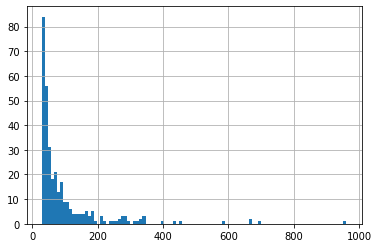

In [ ]:
users_with_enough_interactions_df["prefScore"].hist(bins=100)

In [ ]:
interactions_from_selected_users_df = users_interactions_df.merge(users_with_enough_interactions_df[["personId"]], 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
interactions_from_selected_users_df.shape

(29114, 4)

In [ ]:
interactions_from_selected_users_df

,contentId,personId,eventType,prefScore
0,-8949113594875411859,-9223121837663643404,VIEW,1
1,-8377626164558006982,-9223121837663643404,VIEW,1
2,-8208801367848627943,-9223121837663643404,VIEW,1
3,-8187220755213888616,-9223121837663643404,VIEW,1
4,-7423191370472335463,-9223121837663643404,VIEW,1
...,...,...,...,...
29109,8477804012624580461,9210530975708218054,VIEW,1
29110,8526042588044002101,9210530975708218054,VIEW,1
29111,8856169137131817223,9210530975708218054,VIEW,1
29112,8869347744613364434,9210530975708218054,VIEW,1


###arcticles EDA and cleaning

In [ ]:
articles_df[0:2]

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


In [ ]:
articles_df.lang.value_counts()

en    2264
pt     850
la       4
ja       2
es       2
Name: lang, dtype: int64

For our case of demonstrating content based filtering we are interested only in the PersonId-ContentId-Action information + the title and text of the Contents as we will left only english texts.

In [ ]:
articles_df = articles_df[articles_df["lang"]=="en"]
articles_df = articles_df[["contentId","title","text"]]
articles_df[0:2]

,contentId,title,text
0,-6451309518266745024,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...


In [ ]:
#leave only unique contentIds
articles_df = articles_df.drop_duplicates("contentId")
articles_df.shape

(2218, 3)

###Final Cleaning


In [ ]:
print(interactions_from_selected_users_df.shape);
final_interactions = interactions_from_selected_users_df.merge(articles_df, 
               how = 'right',
               left_on = 'contentId',
               right_on = 'contentId')
print(final_interactions.shape)

(29114, 4)
(19947, 6)


In [ ]:
interactions_from_selected_users_df.personId.value_counts()

 3609194402293569455    961
-2626634673110551643    669
-1032019229384696495    648
-1443636648652872475    585
-2979881261169775358    437
                       ... 
-2373656804845892625     30
 4795304184119033503     30
 2652684983165843086     28
 264882333231965121      27
 4417246933621591943     27
Name: personId, Length: 325, dtype: int64

In [ ]:
final_interactions_count_df = final_interactions.groupby('personId').sum().reset_index()[["personId","prefScore"]]
final_interactions_count_df = final_interactions_count_df[final_interactions_count_df["prefScore"]>=30]
final_users_with_enough_interactions_df = final_interactions_count_df[final_interactions_count_df["prefScore"]>=30]

print('# users after filtering:',final_users_with_enough_interactions_df.shape[0])
print('# interactions after filtering:',final_interactions_count_df.shape[0])

# users after filtering: 192
# interactions after filtering: 192


In [ ]:
final_interactions = final_interactions.merge(final_users_with_enough_interactions_df[["personId"]], 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# interactions after final filtering:',final_interactions.shape[0])

# interactions after final filtering: 17109


In [ ]:
interactions_train_df, interactions_test_df = train_test_split(final_interactions,
                                   stratify=final_interactions['personId'], 
                                   test_size=0.30,
                                   random_state=13)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 11976
# interactions on Test set: 5133


#Content Based Recommender


In [ ]:
# train set is at interactions_train_df 
# test set is at interactions_test_df

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords_list = stopwords.words('english')

vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     #min_df=0.005,
                     #max_df=0.5,
                     max_features=1000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + " " + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()


In [ ]:
print(tfidf_matrix.shape)
print(tfidf_feature_names)

(2218, 1000)
['000', '10', '100', '12', '15', '20', '2014', '2015', '2016', '30', '50', 'ability', 'able', 'access', 'according', 'account', 'accounts', 'achieve', 'across', 'action', 'active', 'activity', 'actual', 'actually', 'ad', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'advanced', 'advantage', 'agile', 'ago', 'ai', 'algorithm', 'algorithms', 'allow', 'allowing', 'allows', 'almost', 'along', 'already', 'also', 'although', 'always', 'amazon', 'among', 'amount', 'analysis', 'analytics', 'android', 'announced', 'another', 'answer', 'anyone', 'anything', 'api', 'apis', 'app', 'apple', 'application', 'applications', 'apply', 'approach', 'apps', 'architecture', 'area', 'areas', 'around', 'article', 'artificial', 'artificial intelligence', 'ask', 'asked', 'attention', 'author', 'automated', 'automatically', 'available', 'average', 'avoid', 'away', 'aws', 'back', 'background', 'bad', 'bank', 'banking', 'banks', 'base', 'based', 'basic', 'become', 'becomes', 'behavior'

## Build User Profiles
The profiles are build from all the content which the user engaded with with taken the scores in consideration

In [ ]:
# calculate user profiles from train dataset
user_profiles = {}
for person_id in interactions_train_df.personId.unique():
  user_profile = None
  interactions_person_df = interactions_train_df[interactions_train_df["personId"]==person_id]
  all_scores = interactions_person_df.prefScore.sum()
  for index, row in interactions_person_df.iterrows():
    content_id = row["contentId"]
    score = row["prefScore"]
    if(user_profile==None):
      user_profile = tfidf_matrix[item_ids.index(content_id)]*score/all_scores
    else:
      user_profile = scipy.sparse.vstack((user_profile,tfidf_matrix[item_ids.index(content_id)]*score/all_scores))
  user_profiles[person_id] = user_profile

### Evaluate

In [ ]:
#recommend items to the users from the test dataset 
#Evaluation is with MRR (https://en.wikipedia.org/wiki/Mean_reciprocal_rank)

In [ ]:
mrr = 0
for person_id in interactions_train_df.personId.unique():
  cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
  #print(cosine_similarities)
  similar_indices = cosine_similarities.argsort().flatten()[-1000:]
  items_to_ignore = interactions_train_df[interactions_train_df["personId"]==person_id]["contentId"].values
  items_to_evaluate = interactions_test_df[interactions_test_df["personId"]==person_id]["contentId"].values
  similar_indices_filtered = list(filter(lambda x: item_ids[x] not in items_to_ignore, similar_indices))
  print("after filtering train set items for person ", person_id, " = ",len(similar_indices_filtered))
  
  first_rank = len(similar_indices_filtered);
  l = len(similar_indices_filtered);
  for i in range(l):
    if(item_ids[similar_indices_filtered[l-i-1]] in items_to_evaluate):
      first_rank = i+1;
      break;
  mrr =mrr+ 1/first_rank
  print("first rank = ",first_rank);
  print("number of train items=",len(items_to_ignore))
mrr = mrr / interactions_train_df.personId.nunique()
print("mrr = ",mrr)

after filtering train set items for person  -1.4436366486528724e+18  =  778
first rank =  4
number of train items= 363
after filtering train set items for person  -7.092877180347316e+17  =  923
first rank =  3
number of train items= 164
after filtering train set items for person  7.890134385692541e+18  =  976
first rank =  5
number of train items= 41
after filtering train set items for person  8.018955947177723e+17  =  947
first rank =  61
number of train items= 101
after filtering train set items for person  5.621833459783231e+18  =  950
first rank =  64
number of train items= 80
after filtering train set items for person  4.2095174786603725e+18  =  946
first rank =  3
number of train items= 94
after filtering train set items for person  7.3929904654096e+18  =  940
first rank =  15
number of train items= 105
after filtering train set items for person  -1.3874643583347587e+18  =  973
first rank =  59
number of train items= 57
after filtering train set items for person  4.43237333160891